# 노드 11. 영화리뷰 텍스트 감성분석하기

In [ ]:
!mkdir -p content/work/sentiment_classification

# 실습에 활용할 수 있도록 라이브러리 설치 및 다운그레이드를 수행합니다
!pip install gensim==4.3.2
!conda install scipy==1.12.0 numpy==1.26.3 -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=26332383 sha256=1bafc69ef3aeab8145a032d935cf6c91c2efaae6c3267f4b5187cd705749e86f
  Stored in directory: /root/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
/bin/bash: line 1: conda: command not found


**텍스트 감정분석의 유용성**


*   Q. 텍스트 데이터에서만 얻을 수 있는 유용한 정보는 무엇인가요? 그 유용성은 텍스트 데이터의 어떤 특징으로부터 비롯되는 것인가요?
    *   SNS 등에서 광범위한 분량의 텍스트 데이터를 쉽게 얻을 수 있는데, 이 데이터는 소비자들의 개인적, 감성적 반응이 직접 담겨 있을뿐더러 실시간 트렌드를 빠르게 반영하는 데이터이기도 하다.

*   Q. 텍스트 감성분석 접근법을 크게 2가지로 나누면 무엇과 무엇이 있나요?
    *   기계학습 기반 접근법과 감성사전 기반 접근법

*   Q. 감성분석 등 텍스트 분류 모델이 다른 데이터분석 업무에 어떤 도움을 줄 수 있나요?
    *   일반적인 데이터분석 업무는 범주화가 잘 된 정형데이터를 필요로 하는데, 이런 데이터를 큰 규모로 구축하기 위해서 많은 비용이 들지만, 쉽게 구할 수 있는 비정형데이터인 텍스트에 감성분석 기법을 적용하면 텍스트를 정형데이터로 가공하여 유용한 의사결정 보조자료로 활용할 수 있게 된다.

*   Q. 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법에는 무엇이 있나요?
    *   워드 임베딩(word embedding) 기법


**텍스트 데이터의 특징**
*   텍스트를 숫자로 표현하는 방법
    *   인공지능 모델의 입력이 될 수 있는 것은 0과 1의 비트로 표현 가능한 숫자만으로 이루어진 매트릭스일 뿐임
    *   A=0, B=1, ..., Z=25 라고 숫자를 임의로 부여한다고 하면 의미적으로 A와 B는 1만큼 멀고, A와 Z는 25만큼 멀지 않고 텍스트의 중요한 특징은 그 자체로는 기호일 뿐이며, 텍스트가 내포하는 의미를 기호가 직접 내포하지 않음



In [ ]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [ ]:
# 우리의 텍스트 데이터로부터 사전을 만들기 위해 모든 문장을 단어 단위로 쪼갠 후에 파이썬 딕셔너리(dict) 자료구조로 표현

index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다.
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다.
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

# 단어 10개짜리 작은 딕셔너리가 만들어졌습니다.
# 하지만 우리가 가진 텍스트 데이터를 숫자로 바꿔 보려고 하는데, 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조여야 합니다.

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [ ]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [ ]:
# 이 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환하는 방식으로 사용

print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

# 이렇게 텍스트 혹은 범주형 데이터를 정수에 대응하는 방법을‘정수 인코딩’이라고 합니다

[1, 3, 6, 7]


In [ ]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [ ]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
# 반대로, encode된 벡터를 decode하여 다시 원래 텍스트 데이터로 복구할 수도 있습니다.

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [ ]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


**Embedding 레이어의 등장**
*   임베딩(Embedding)이란 자연어 처리(Natural Language Processing)분야에서 임베딩(Embedding)은 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 전체를 의미

In [ ]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다.

import torch
import torch.nn as nn
import numpy as np
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_vector_dim, padding_idx=0)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
raw_inputs_tensor = torch.tensor(raw_inputs, dtype=torch.long)
output = embedding(raw_inputs_tensor)
print(output)

# 실행해 보니 에러가 발생합니다. 왜 그럴까요?
# 주의해야 할 점이 있습니다.
# Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다.
# raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5입니다.
# Pytorch에서는 torch.nn.utils.rnn.pad_sequence라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
import torch.nn.functional as F

raw_inputs = [torch.tensor(sentence, dtype=torch.long) for sentence in raw_inputs]
raw_inputs = torch.nn.utils.rnn.pad_sequence(raw_inputs, batch_first=True, padding_value=word_to_index['<PAD>'])
print(raw_inputs)

tensor([[1, 3, 4, 5, 0],
        [1, 3, 6, 7, 0],
        [1, 8, 3, 4, 9]])


In [ ]:
# 짧은 문장 뒤쪽이 0으로 채워지는 것을 확인할 수 있습니다. <PAD> 가 0에 매핑되어 있다는 걸 기억하세요.
# 그러면 위에 시도했던 output = embedding(raw_inputs)을 다시 시도해 봅시다.

vocab_size = len(word_to_index)   # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4   # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=word_to_index['<PAD>'])

# nn.Embedding를 통해 word vector를 모두 일정 길이로 맞춰주어야
# embedding 레이어의 input이 될 수 있음에 주의해 주세요.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
maxlen = 5
padded_sentences = [sentence + [word_to_index['<PAD>']] * (maxlen - len(sentence)) if len(sentence) < maxlen else sentence[:maxlen] for sentence in encoded_sentences]

raw_inputs = torch.tensor(padded_sentences, dtype=torch.long)
output = embedding(raw_inputs)
print(output)

tensor([[[ 0.8843, -2.3911,  1.1333,  1.2005],
         [-0.4936,  1.5700, -0.9654, -1.2543],
         [-0.0056, -0.4597, -0.7949,  1.3470],
         [ 0.3545, -1.0460,  1.0569, -0.5396],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.8843, -2.3911,  1.1333,  1.2005],
         [-0.4936,  1.5700, -0.9654, -1.2543],
         [-0.9422, -1.5004, -0.9289,  0.3514],
         [-0.4212,  1.6360,  0.8597,  0.7761],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.8843, -2.3911,  1.1333,  1.2005],
         [-1.5362,  0.9110,  0.5356,  1.6957],
         [-0.4936,  1.5700, -0.9654, -1.2543],
         [-0.0056, -0.4597, -0.7949,  1.3470],
         [ 1.8689, -1.0848, -1.6644,  1.0270]]], grad_fn=<EmbeddingBackward0>)


**시퀀스 데이터를 다루는 RNN**

    *   at time=0s : 듣는이의 귀에 들어온 input='i'
    *   at time=1s : 듣는이의 귀에 들어온 input='feel'
    *   at time=2s : 듣는이의 귀에 들어온 input='hungry'

*   time=1s인 시점에서 입력으로 받은 문장은 'i feel' 까지이며, 그다음에 'hungry'가 올지, 'happy'가 올지 알 수 없는 상황
*   RNN은 그런 상황을 묘사하기에 가장 적당한 모델 구조를 가지고 있음
*   왜냐하면 RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었기 때문임
*   김성훈 교수의 모두의 딥러닝 강좌 12강.RNN 참조(https://youtu.be/-SHPG_KMUkQ)

*   Q. RNN의 정의대로라면 t=4 시점의 state h4는 t=4 시점의 input x4와 t=3 시점의 state h3가 결정합니다. 그렇다면 h4에는 t<4 이전의 입력 x1, x2, x3의 정보는 반영되지 않는 것일까요?
    *    h4를 결정하는 이전 state h3 안에 x3의 정보가 반영되어 있고, 같은 원리로 이전 시점의 모든 입력의 정보가 현재 상태에 반영될 수 있습니다.

*   시퀀스 자료형과 RNN에 대한 모두의 연구소 유튜브 참조(https://www.youtube.com/watch?v=mG6N0ut9dog&t=1447s)



In [ ]:
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현

class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.
model = Model_1(vocab_size, word_vector_dim)

print(model)

Model_1(
  (embedding): Embedding(10, 4)
  (lstm): LSTM(4, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**꼭 RNN이어야 할까?**
*   텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있음
*   이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있는데 이미지는 시퀀스 데이터가 아니므로 이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용
*   1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용
*   CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점
*   아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있음
*    방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있음
*   이 외에도 1-D CNN과 RNN 레이어를 섞어 쓴다거나, FFN(FeedForward Network) 레이어만으로 구성하거나, 혹은 최근 각광받고 있는 Transformer 레이어를 쓰는 등 매우 다양한 시도를 해볼 수 있음

In [ ]:
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_2(vocab_size, word_vector_dim)

print(model)

Model_2(
  (embedding): Embedding(10, 4)
  (conv1): Conv1d(4, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_3(vocab_size, word_vector_dim)

print(model)

Model_3(
  (embedding): Embedding(10, 4)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**IMDB 영화리뷰 감성분석**

IMDB 데이터셋 분석


*   2011년 Learning Word Vectors for Sentiment Analysis 논문에서 이 데이터셋을 소개(https://aclanthology.org/P11-1015.pdf)
*    IMDb Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨이 달려 있음
*    50000개의 리뷰 중 절반인 25000개가 훈련용 데이터, 나머지 25000개를 테스트용 데이터로 사용하도록 지정되어 있음



In [ ]:
import os
import numpy as np

# 원본 IMDb 데이터셋 다운로드
# import tensorflow as tf
# imdb = tf.keras.datasets.imdb

# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)


# 이번 실습에서는 미리 다운로드된 데이터셋을 불러와 활용하겠습니다

data_dir = '/content/content/work'

x_train = np.load(os.path.join(data_dir, 'imdb_x_train.npy'), allow_pickle=True)
y_train = np.load(os.path.join(data_dir, 'imdb_y_train.npy'), allow_pickle=True)
x_test  = np.load(os.path.join(data_dir, 'imdb_x_test.npy'),  allow_pickle=True)
y_test  = np.load(os.path.join(data_dir, 'imdb_y_test.npy'),  allow_pickle=True)

print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")


훈련 샘플 개수: 25000, 테스트 개수: 25000


In [ ]:
# imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [ ]:
# 텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드했음을 확인할 수 있습니다.
# 이미 텍스트가 encode되었으므로 IMDb 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공합니다.

# word_to_index = imdb.get_word_index()

data_dir = '/content/content/work'

word_to_index = np.load(
    os.path.join(data_dir, 'imdb_word_to_index.pickle'),
    allow_pickle=True
)

index_to_word = {index: word for word, index in word_to_index.items()}

print(index_to_word[1])     # 'the'
print(word_to_index['the'])  # 1

the
1


In [ ]:
# 함수 정의

def get_decoded_sentence(sequence, index_to_word):
    return ' '.join(
        [index_to_word.get(idx, '<UNK>') for idx in sequence]
    )


In [ ]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

#IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 보정이 필요
#예를 들어 다음 코드를 실행시켜보면 보정이 되지 않은 상태라 문장이 이상함을 확인

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have tw

In [ ]:
# 매핑 보정 작업
# 아래 내용은 Tensorflow 튜토리얼의 가이드를 반영하여 작성

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.

word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
# word_to_index는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 이 출력됩니다.
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

# 다운로드한 데이터셋이 확인
# 보정 후 x_train[0] 데이터도 자연스러운 문장으로 변경

<BOS>
4
the
<BOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be prais

In [ ]:
# encode된 텍스트가 정상적으로 decode 되는지 확인

print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<BOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what 

In [ ]:
# decode 한 문장과 라벨을 비교하여 일치하는지 확인해 주세요.
# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
# 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다.
# 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다.

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

# 위의 경우에는 maxlen=580이 됩니다.
# 또 한 가지 유의해야 하는 것은 padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
# 두 가지 방식을 한 번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보시기 바랍니다.

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
import numpy as np
import torch

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([25000, 580])


Q. RNN 활용 시 pad_sequences의 padding 방식은 'post'와 'pre' 중 어느 것이 유리할까요? 그 이유는 무엇일까요?
*   RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.


**딥러닝 모델 설계와 훈련**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([15000, 580])
(15000,)


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipython-input-1424571675.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipython-input-1424571675.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6936, Train Accuracy: 0.5035 - Validation Loss: 0.6934, Validation Accuracy: 0.4944
Epoch 2/30 - Train Loss: 0.6932, Train Accuracy: 0.5052 - Validation Loss: 0.6934, Validation Accuracy: 0.4962
Epoch 3/30 - Train Loss: 0.6932, Train Accuracy: 0.5068 - Validation Loss: 0.6934, Validation Accuracy: 0.4975
Epoch 4/30 - Train Loss: 0.6931, Train Accuracy: 0.5080 - Validation Loss: 0.6933, Validation Accuracy: 0.4981
Epoch 5/30 - Train Loss: 0.6929, Train Accuracy: 0.5091 - Validation Loss: 0.6933, Validation Accuracy: 0.4975
Epoch 6/30 - Train Loss: 0.6929, Train Accuracy: 0.5101 - Validation Loss: 0.6933, Validation Accuracy: 0.4976
Epoch 7/30 - Train Loss: 0.6928, Train Accuracy: 0.5110 - Validation Loss: 0.6932, Validation Accuracy: 0.4987
Epoch 8/30 - Train Loss: 0.6926, Train Accuracy: 0.5113 - Validation Loss: 0.6932, Validation Accuracy: 0.4995
Epoch 9/30 - Train Loss: 0.6925, Train Accuracy: 0.5117 - Validation Loss: 0.6931, Validation Accuracy: 0.4994
E

In [ ]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.7156, Test Accuracy: 0.5042


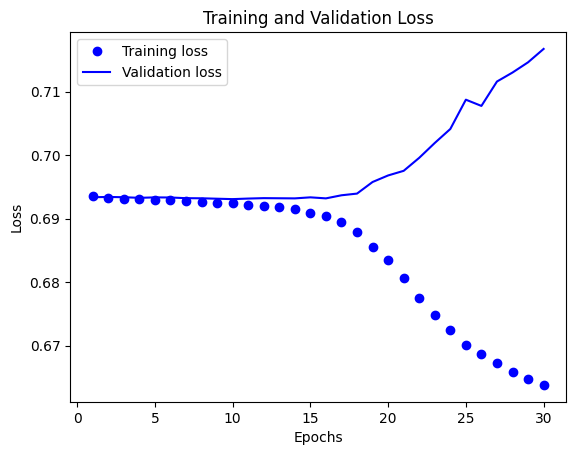

In [ ]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다.
# validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.

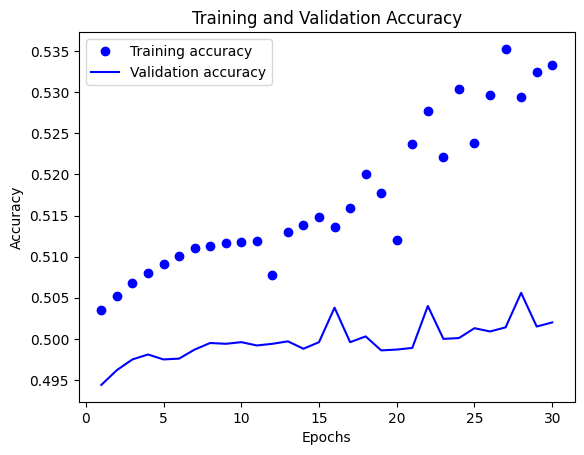

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Word2Vec의 적용**

In [ ]:
!mkdir -p /content/content/work
!pip install gensim==4.3.2
!pip install scipy==1.12.0 numpy==1.26.3

In [ ]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

In [ ]:
!mkdir /content/content/work

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.

base_dir = '/content/content/work/sentiment_classification/word2vec_emb'
os.makedirs(base_dir, exist_ok=True)

word2vec_file_path = os.path.join(base_dir, 'word2vec.txt')

vectors = model.embedding.weight.detach().cpu().numpy()
vocab_size, word_vector_dim = vectors.shape

with open(word2vec_file_path, 'w', encoding='utf-8') as f:
    # Word2Vec 헤더
    f.write(f"{vocab_size - 4} {word_vector_dim}\n")  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    for i in range(4, vocab_size):
        word = index_to_word.get(i)
        if word is None:
            continue
        vector_str = ' '.join(map(str, vectors[i]))
        f.write(f"{word} {vector_str}\n")

print("저장 완료:", word2vec_file_path)


In [ ]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용 가능

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

In [ ]:
#위와 같이 얻은 워드 벡터를 가지고 재미있는 실험을 해볼 수 있습니다.
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다.
# gensim을 사용하면 아래와 같이 해볼 수 있습니다.

word_vectors.similar_by_word("love")

# Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었습니다.
# 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것입니다.
# Word2Vec이 학습되는 원리에 대해서는 차후 깊이 있게 다루게 될 것입니다.
# 하지만 그렇게 해서 학습된 Word2Vec이라는 것도 실은 방금 우리가 파일에 써본 Embedding Layer와 원리는 동일합니다.

Q. 사전에 학습된 Word2Vec 등의 임베딩 모델을 활용하는 전이학습(Transfer Learning)이 유리한 이유를 설명해 보세요.
*   사람도 무언가를 배우기 위해 제로베이스에서 시작하지 않고 자신이 지닌 이전의 경험과 지식을 동원하는 것처럼, 광범위한 데이터를 통해 미리 학습해 놓은 임베딩 속에 녹아 있는 의미, 문법 등의 부가적인 정보를 내가 만들려는 모델이 활용할 수 있는 피처로 활용하는 것이 훨씬 빠르고 정확하게 학습할 수 있는 방법이 된다.



In [ ]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

# 300dim의 벡터로 이루어진 300만 개의 단어입니다.
# 이 단어 사전을 메모리에 모두 로딩하면 아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다.
# 그래서 KeyedVectors.load_word2vec_format 메서드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.
# 메모리가 충분하다면 limt=None으로 하시면 300만 개를 모두 로딩합니다.

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

# Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인 가능

In [ ]:
# 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 20    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

In [ ]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

# Word2Vec을 정상적으로 잘 활용하면 그렇지 않은 경우보다 5% 이상의 성능 향상이 발생합니다.
# 적절한 모델 구성, 하이퍼파라미터를 고려하여 감정 분석 모델의 성능을 최대한으로 끌어올려 봅시다.

# 노드 12. 영화리뷰 텍스트 감성분석하기[프로젝트]

**실험 목적**

*   네이버 영화리뷰 데이터에 대해 가시적인 성능향상 구현(Validation Accuracy ≥ 85%)
*   gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석(gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석)
*   3가지 이상의 모델을 시도하여 Text Classification 태스크를 성공적으로 구현


**가설 설정**

*   문맥 정보를 순차적으로 학습하는 LSTM 계열 모델은 지역적 특징을 중심으로 학습하는 CNN 모델보다 감성분석 성능이 우수할 것이다.
*   BiLSTM 모델은 단방향 LSTM보다 더 풍부한 문맥 정보를 활용하여 감성분석 정확도가 더 높을 것이다.


**실험 조건**

*   데이터셋 : 네이버 영화 리뷰 데이터
*   전처리 : 중복 제거, 결측 제거, 불용어 제거(조사, 어미 등의 불필요 단어)
*   패딩방식 : pad_sequence
*   비교 모델 : Embedding + LSTM, Embedding + CNN, Embedding + BiLSTM(BiLSTM 모델은 논문 "Highway BiLSTM-CRFs 모델을 이용한 한국어 의미역 결정'에서 참조(https://www.koreascience.or.kr/article/CFKO201731951960076.pdf))
*   Batch Size : 64
*   Epoch : 20


**네이버 영화리뷰 감성분석 도전하기**

In [ ]:
# 다운로드 진행

!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!mv ratings_*.txt content

--2026-01-29 09:19:20--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.02s   

2026-01-29 09:19:22 (562 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2026-01-29 09:19:23--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet-

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 38.1 MB/s eta 0:00:00
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2026-01-29 09:19:34--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.134, 13.200.41.135, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.134|:443... connected.
HTTP request sent, await

**라이브러리 버전 확인**

In [ ]:
!python --version

Python 3.12.12


In [ ]:
!pip install gensim==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 55.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=26332408 sha256=5763fb8c022b96e765f2706858d3530dd7bc04c5e27fd240afa3063b6d4509e7
  Stored in directory: /root/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim


In [ ]:
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.3 which is incompatible.
music21 9.9.1 requires numpy>=1.26.4, but you have numpy 1.26.3 which is incompatible.
access 1.1.10.post3 requires scipy>

In [ ]:
import pandas
import numpy
import gensim
import konlpy

print(numpy.__version__)
print(pandas.__version__)
print(gensim.__version__)
print(konlpy.__version__)

1.26.3
2.2.2
4.3.2
0.6.0


**1) 데이터 준비와 확인**

In [ ]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
base_dir = '/content'

train_data = pd.read_table(os.path.join(base_dir, 'ratings_train.txt'))
test_data  = pd.read_table(os.path.join(base_dir, 'ratings_test.txt'))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


**2) 데이터로더 구성**
*   실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.
*   그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.
*   항이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.
*   data_loader 안에서는 다음을 수행해야 합니다.
    *   데이터의 중복 제거
    *   NaN 결측치 제거
    *   한국어 토크나이저로 토큰화
    *   불용어(Stopwords) 제거
    *   사전word_to_index 구성
    *   텍스트 스트링을 사전 인덱스 스트링으로 변환
    *   X_train, y_train, X_test, y_test, word_to_index 리턴

In [ ]:
# 기본 설정

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [ ]:
tokenizer = Mecab()

stopwords = [
    '의','가','이','은','들','는','좀','잘','걍','과','도',
    '를','으로','자','에','와','한','하다'
]

In [ ]:
# 특수 토큰 정의(임베딩 오류때문에 수정)

PAD = "<PAD>"
BOS = "<BOS>"
UNK = "<UNK>"
UNUSED = "<UNUSED>"

In [ ]:
def load_data(train_data, test_data, num_words=10000):
    # 중복 / 결측 제거
    train_data = train_data.drop_duplicates(subset=['document']).dropna()
    test_data  = test_data.drop_duplicates(subset=['document']).dropna()

    # 토큰화 + 불용어 제거
    X_train_tok = []
    for sentence in train_data['document']:
        tokens = tokenizer.morphs(sentence)
        tokens = [w for w in tokens if w not in stopwords]
        X_train_tok.append(tokens)

    X_test_tok = []
    for sentence in test_data['document']:
        tokens = tokenizer.morphs(sentence)
        tokens = [w for w in tokens if w not in stopwords]
        X_test_tok.append(tokens)

    # vocab 구성 (특수 토큰 포함)
    words = np.concatenate(X_train_tok).tolist()
    counter = Counter(words).most_common(num_words - 4)

    vocab = [PAD, BOS, UNK, UNUSED] + [word for word, _ in counter]
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}

    # 토큰 → 인덱스 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[BOS]] + [
            word_to_index[word] if word in word_to_index else word_to_index[UNK]
            for word in wordlist
        ]

    X_train = list(map(wordlist_to_indexlist, X_train_tok))
    X_test  = list(map(wordlist_to_indexlist, X_test_tok))

    y_train = np.array(train_data['label'].values)
    y_test  = np.array(test_data['label'].values)

    return X_train, y_train, X_test, y_test, word_to_index, index_to_word

In [ ]:
# 데이터 로더 실행

X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(
    train_data, test_data
)

**3) 모델 구성을 위한 데이터 분석 및 가공**
*   데이터셋 내 문장 길이 분포
*   적절한 최대 문장 길이 지정
*   torch.nn.utils.rnn.pad_sequence 을 활용한 패딩 추가


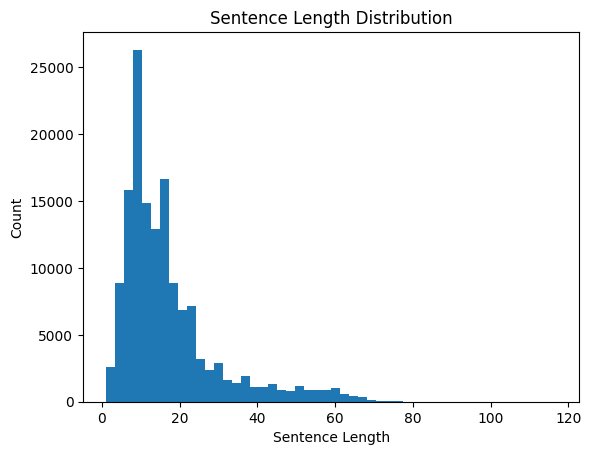

평균 길이: 16.983137458784256
최대 길이: 117


In [ ]:
# 데이터셋 내 문장 길이 분포

import matplotlib.pyplot as plt

sentence_lengths = [len(x) for x in X_train]

plt.hist(sentence_lengths, bins=50)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Sentence Length Distribution")
plt.show()

print("평균 길이:", sum(sentence_lengths)/len(sentence_lengths))
print("최대 길이:", max(sentence_lengths))


In [ ]:
# 최대 문장 길이 지정(평균 20이내 이므로 리뷰 특성상 50 이내로 커버될 것으로 사료되어 지정)

MAX_LEN = 50

In [ ]:
# torch.nn.utils.rnn.pad_sequence을 활용한 패딩 추가

import torch
from torch.nn.utils.rnn import pad_sequence

PAD_IDX = word_to_index["<PAD>"]

def pad_sequences(sequences, max_len):
    sequences = [
        torch.tensor(seq[:max_len], dtype=torch.long)
        for seq in sequences
    ]
    return pad_sequence(
        sequences,
        batch_first=True,
        padding_value=PAD_IDX
    )

X_train_pad = pad_sequences(X_train, MAX_LEN)
X_test_pad  = pad_sequences(X_test, MAX_LEN)

y_train = torch.tensor(y_train)
y_test  = torch.tensor(y_test)

**4) 모델 구성 및 validation set 구성**

In [ ]:
# Train과 Validation 분리

from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_pad, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [ ]:
# 임베딩 + LSTM

import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1])

In [ ]:
# 임베딩 + CNN

class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=PAD_IDX
        )
        self.conv = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        emb = self.embedding(x).transpose(1, 2)
        conv = torch.relu(self.conv(emb))
        pooled = torch.max(conv, dim=2)[0]
        return self.fc(pooled)

In [ ]:
# 임베딩 + BiLSTM

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h_cat)

**5) 모델 훈련 개시**

In [ ]:
# 데이터로더 생성

from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=64
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BiLSTMClassifier(len(word_to_index)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_accs = [], []

for epoch in range(20):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = correct / total
    val_accs.append(acc)

    print(f"Epoch {epoch+1}, Loss {train_losses[-1]:.4f}, Val Acc {acc:.4f}")


Epoch 1, Loss 0.4254, Val Acc 0.8440
Epoch 2, Loss 0.3122, Val Acc 0.8586
Epoch 3, Loss 0.2603, Val Acc 0.8656
Epoch 4, Loss 0.2129, Val Acc 0.8640
Epoch 5, Loss 0.1694, Val Acc 0.8612
Epoch 6, Loss 0.1289, Val Acc 0.8597
Epoch 7, Loss 0.0975, Val Acc 0.8564
Epoch 8, Loss 0.0742, Val Acc 0.8557
Epoch 9, Loss 0.0587, Val Acc 0.8509
Epoch 10, Loss 0.0458, Val Acc 0.8500
Epoch 11, Loss 0.0402, Val Acc 0.8515
Epoch 12, Loss 0.0341, Val Acc 0.8491
Epoch 13, Loss 0.0320, Val Acc 0.8514
Epoch 14, Loss 0.0264, Val Acc 0.8483
Epoch 15, Loss 0.0239, Val Acc 0.8526
Epoch 16, Loss 0.0239, Val Acc 0.8497
Epoch 17, Loss 0.0228, Val Acc 0.8509
Epoch 18, Loss 0.0223, Val Acc 0.8500
Epoch 19, Loss 0.0207, Val Acc 0.8503
Epoch 20, Loss 0.0158, Val Acc 0.8495


**6) Loss, Accuracy 그래프 시각화**

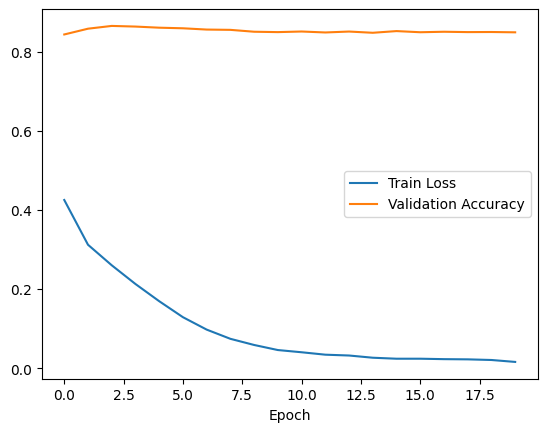

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

**7) 학습된 Embedding 레이어 분석**

In [ ]:
# 임베딩 벡터 추출

embedding_weights = model.embedding.weight.detach().cpu().numpy()

In [ ]:
# 코사인 유사도 기반 단어 분석

from sklearn.metrics.pairwise import cosine_similarity

def most_similar(word, topk=5):
    idx = word_to_index[word]
    sims = cosine_similarity(
        embedding_weights[idx].reshape(1, -1),
        embedding_weights
    )[0]
    top = sims.argsort()[-topk-1:-1][::-1]
    return [index_to_word[i] for i in top]

most_similar("코미디")

['도저', '명탐정', '재탕', '거늘', '해리포터']

**8) 한국어 Word2Vec 임베딩 활용하여 성능 개선**



*   한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용
*   한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델 구현
*   모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용



In [ ]:
# Word2Vec 로드

from gensim.models import Word2Vec

w2v = Word2Vec.load("/content/word2vec_ko.model")

In [ ]:
# Embedding 매트릭스 생성

embedding_dim = w2v.vector_size

embedding_matrix = np.random.normal(
    0, 0.01, (len(word_to_index), embedding_dim)
)

for word, idx in word_to_index.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]

In [ ]:
# Word2Vec + LSTM

class Word2VecLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(
            embedding_matrix.shape[1],
            128,
            batch_first=True
        )
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1])

In [ ]:
# Word2Vec + CNN

class Word2VecCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.conv = nn.Conv1d(
            embedding_matrix.shape[1],
            100,
            kernel_size=3
        )
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        emb = self.embedding(x).transpose(1, 2)
        conv = torch.relu(self.conv(emb))
        pooled = torch.max(conv, dim=2)[0]
        return self.fc(pooled)

In [ ]:
# Word2Vec + BiLSTM

class Word2VecBiLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(
            embedding_matrix.shape[1],
            128,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(256, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h_cat)

In [ ]:
# 공통학습 및 평가함수

def train_and_evaluate(model, train_loader, val_loader, epochs=20):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    val_accs = []

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        acc = correct / total
        val_accs.append(acc)

        print(f"Epoch {epoch+1} | Val Acc: {acc:.4f}")

    return val_accs[-1]   # 실제 최종 Validation Accuracy


In [ ]:
results = {
    "LSTM": {},
    "CNN": {},
    "BiLSTM": {}
}

In [ ]:
results["LSTM"]["random"] = train_and_evaluate(
    LSTMClassifier(len(word_to_index)),
    train_loader,
    val_loader
)

results["CNN"]["random"] = train_and_evaluate(
    CNNClassifier(len(word_to_index)),
    train_loader,
    val_loader
)

results["BiLSTM"]["random"] = train_and_evaluate(
    BiLSTMClassifier(len(word_to_index)),
    train_loader,
    val_loader
)

Epoch 1 | Val Acc: 0.5078
Epoch 2 | Val Acc: 0.5059
Epoch 3 | Val Acc: 0.8433
Epoch 4 | Val Acc: 0.8548
Epoch 5 | Val Acc: 0.8576
Epoch 6 | Val Acc: 0.8580
Epoch 7 | Val Acc: 0.8516
Epoch 8 | Val Acc: 0.8509
Epoch 9 | Val Acc: 0.8502
Epoch 10 | Val Acc: 0.8454
Epoch 11 | Val Acc: 0.8475
Epoch 12 | Val Acc: 0.8413
Epoch 13 | Val Acc: 0.8429
Epoch 14 | Val Acc: 0.8444
Epoch 15 | Val Acc: 0.8419
Epoch 16 | Val Acc: 0.8399
Epoch 17 | Val Acc: 0.8410
Epoch 18 | Val Acc: 0.8418
Epoch 19 | Val Acc: 0.8412
Epoch 20 | Val Acc: 0.8414
Epoch 1 | Val Acc: 0.8356
Epoch 2 | Val Acc: 0.8442
Epoch 3 | Val Acc: 0.8433
Epoch 4 | Val Acc: 0.8309
Epoch 5 | Val Acc: 0.8352
Epoch 6 | Val Acc: 0.8382
Epoch 7 | Val Acc: 0.8408
Epoch 8 | Val Acc: 0.8375
Epoch 9 | Val Acc: 0.8344
Epoch 10 | Val Acc: 0.8359
Epoch 11 | Val Acc: 0.8333
Epoch 12 | Val Acc: 0.8348
Epoch 13 | Val Acc: 0.8361
Epoch 14 | Val Acc: 0.8325
Epoch 15 | Val Acc: 0.8340
Epoch 16 | Val Acc: 0.8324
Epoch 17 | Val Acc: 0.8341
Epoch 18 | Val Acc:

In [ ]:
results["LSTM"]["w2v"] = train_and_evaluate(
    Word2VecLSTM(embedding_matrix),
    train_loader,
    val_loader
)

results["CNN"]["w2v"] = train_and_evaluate(
    Word2VecCNN(embedding_matrix),
    train_loader,
    val_loader
)

results["BiLSTM"]["w2v"] = train_and_evaluate(
    Word2VecBiLSTM(embedding_matrix),
    train_loader,
    val_loader
)

Epoch 1 | Val Acc: 0.5495
Epoch 2 | Val Acc: 0.8437
Epoch 3 | Val Acc: 0.8574
Epoch 4 | Val Acc: 0.8611
Epoch 5 | Val Acc: 0.8626
Epoch 6 | Val Acc: 0.8559
Epoch 7 | Val Acc: 0.8588
Epoch 8 | Val Acc: 0.8543
Epoch 9 | Val Acc: 0.8542
Epoch 10 | Val Acc: 0.8520
Epoch 11 | Val Acc: 0.8487
Epoch 12 | Val Acc: 0.8461
Epoch 13 | Val Acc: 0.8466
Epoch 14 | Val Acc: 0.8496
Epoch 15 | Val Acc: 0.8414
Epoch 16 | Val Acc: 0.8437
Epoch 17 | Val Acc: 0.8444
Epoch 18 | Val Acc: 0.8471
Epoch 19 | Val Acc: 0.8454
Epoch 20 | Val Acc: 0.8452
Epoch 1 | Val Acc: 0.8370
Epoch 2 | Val Acc: 0.8386
Epoch 3 | Val Acc: 0.8567
Epoch 4 | Val Acc: 0.8557
Epoch 5 | Val Acc: 0.8573
Epoch 6 | Val Acc: 0.8572
Epoch 7 | Val Acc: 0.8540
Epoch 8 | Val Acc: 0.8471
Epoch 9 | Val Acc: 0.8440
Epoch 10 | Val Acc: 0.8416
Epoch 11 | Val Acc: 0.8461
Epoch 12 | Val Acc: 0.8444
Epoch 13 | Val Acc: 0.8416
Epoch 14 | Val Acc: 0.8392
Epoch 15 | Val Acc: 0.8393
Epoch 16 | Val Acc: 0.8363
Epoch 17 | Val Acc: 0.8372
Epoch 18 | Val Acc:

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1])


class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.conv = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        emb = self.embedding(x).transpose(1, 2)
        conv = torch.relu(self.conv(emb))
        pooled = torch.max(conv, dim=2)[0]
        return self.fc(pooled)


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h_cat)


In [ ]:
class Word2VecLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1])


class Word2VecCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.conv = nn.Conv1d(embedding_matrix.shape[1], 100, kernel_size=3)
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        emb = self.embedding(x).transpose(1, 2)
        conv = torch.relu(self.conv(emb))
        pooled = torch.max(conv, dim=2)[0]
        return self.fc(pooled)


class Word2VecBiLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float),
            freeze=False,
            padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(
            embedding_matrix.shape[1], 128,
            batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(256, 2)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h_cat)


In [ ]:
def train_and_evaluate(model, train_loader, val_loader, epochs=20):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    val_accs = []

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        acc = correct / total
        val_accs.append(acc)
        print(f"Epoch {epoch+1} | Val Acc: {acc:.4f}")

    # 최고값 사용
    return max(val_accs)


In [ ]:
results = {
    "LSTM": {},
    "CNN": {},
    "BiLSTM": {}
}

# Random Init
results["LSTM"]["random"] = train_and_evaluate(
    LSTMClassifier(len(word_to_index)), train_loader, val_loader
)
results["CNN"]["random"] = train_and_evaluate(
    CNNClassifier(len(word_to_index)), train_loader, val_loader
)
results["BiLSTM"]["random"] = train_and_evaluate(
    BiLSTMClassifier(len(word_to_index)), train_loader, val_loader
)

# Word2Vec
results["LSTM"]["w2v"] = train_and_evaluate(
    Word2VecLSTM(embedding_matrix), train_loader, val_loader
)
results["CNN"]["w2v"] = train_and_evaluate(
    Word2VecCNN(embedding_matrix), train_loader, val_loader
)
results["BiLSTM"]["w2v"] = train_and_evaluate(
    Word2VecBiLSTM(embedding_matrix), train_loader, val_loader
)


Epoch 1 | Val Acc: 0.5388
Epoch 2 | Val Acc: 0.7028
Epoch 3 | Val Acc: 0.7881
Epoch 4 | Val Acc: 0.8310
Epoch 5 | Val Acc: 0.8485
Epoch 6 | Val Acc: 0.8530
Epoch 7 | Val Acc: 0.8528
Epoch 8 | Val Acc: 0.8528
Epoch 9 | Val Acc: 0.8483
Epoch 10 | Val Acc: 0.8466
Epoch 11 | Val Acc: 0.8424
Epoch 12 | Val Acc: 0.8406
Epoch 13 | Val Acc: 0.8400
Epoch 14 | Val Acc: 0.8381
Epoch 15 | Val Acc: 0.8370
Epoch 16 | Val Acc: 0.8374
Epoch 17 | Val Acc: 0.8400
Epoch 18 | Val Acc: 0.8339
Epoch 19 | Val Acc: 0.8373
Epoch 20 | Val Acc: 0.8377
Epoch 1 | Val Acc: 0.8305
Epoch 2 | Val Acc: 0.8424
Epoch 3 | Val Acc: 0.8450
Epoch 4 | Val Acc: 0.8429
Epoch 5 | Val Acc: 0.8394
Epoch 6 | Val Acc: 0.8378
Epoch 7 | Val Acc: 0.8357
Epoch 8 | Val Acc: 0.8339
Epoch 9 | Val Acc: 0.8343
Epoch 10 | Val Acc: 0.8325
Epoch 11 | Val Acc: 0.8315
Epoch 12 | Val Acc: 0.8314
Epoch 13 | Val Acc: 0.8326
Epoch 14 | Val Acc: 0.8319
Epoch 15 | Val Acc: 0.8309
Epoch 16 | Val Acc: 0.8344
Epoch 17 | Val Acc: 0.8336
Epoch 18 | Val Acc:

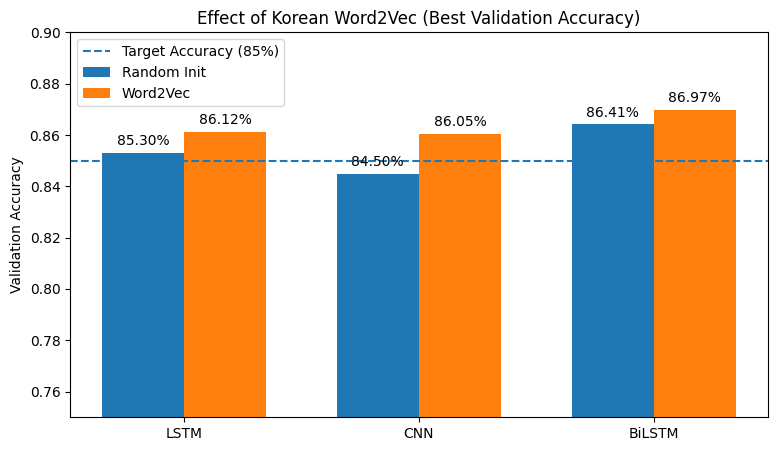

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = list(results.keys())
acc_random = [results[m]["random"] for m in models]
acc_w2v    = [results[m]["w2v"] for m in models]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))
bars1 = plt.bar(x - width/2, acc_random, width, label="Random Init")
bars2 = plt.bar(x + width/2, acc_w2v, width, label="Word2Vec")

plt.axhline(0.85, linestyle="--", label="Target Accuracy (85%)")

for bars in [bars1, bars2]:
    for bar in bars:
        y = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            y + 0.003,
            f"{y:.2%}",
            ha="center",
            fontsize=10
        )

plt.xticks(x, models)
plt.ylim(0.75, 0.90)
plt.ylabel("Validation Accuracy")
plt.title("Effect of Korean Word2Vec (Best Validation Accuracy)")
plt.legend()
plt.show()


**결과 보고서**

*   결과 분석
    *   한국어 Word2Vec 임베딩 적용한 후 최고값(논문 및 실험용의 경우 최고값 사용)을 기준으로 3개 모델 모두 85% 이상의 성능을 발현하였으며 1~2% 사이의 유효 정확도 향상을 보인다는 유의미한 결과를 도출함
    *   마지막 훈련 값을 기준으로도 3개 모델 모두 유효 정확도가 향상되었으나 CNN은 예외적으로 84%에서 정체
    *   Train Loss는 epoch가 증가함에 따라 지속적으로 감소하는 경향을 보임
    *   Validation Loss 역시 초기에는 감소하다가 일정 epoch 이후 완만해지며 수렴
    *   Train Accuracy와 Validation Accuracy는 전반적으로 유사한 추세를 보이며, 급격한 분리는 관찰되지 않았음

*   결과 의미
    *   가설1. 문맥 정보를 순차적으로 학습하는 LSTM 계열 모델은 지역적 특징을 중심으로 학습하는 CNN 모델보다 감성분석 성능이 우수할 것이다.
        *   LSTM 계열 모델은 감성 분석 문제에 높은 적합성을 보였으나 CNN 모델과 큰 성능 차이가 없으므로 실험 전 설정한 가설을 채택하기에 오류가 있을 수 있음
        *   CNN은 n-gram 기반의 국소 패턴(“정말 별로”, “너무 좋다”)을 매우 효과적으로 포착한다는 점에서 문장이 짧고 감성 단어가 명확한 리뷰에서 성능이 강하다고 판단됨
    *   가설2. BiLSTM 모델은 단방향 LSTM보다 더 풍부한 문맥 정보를 활용하여 감성분석 정확도가 더 높을 것이다.
        *   단방향의 LSTM보다 양방향의 BiLSTM에서 높은 성능을 보였다는 점에서 가설 채택 가능
        *   한국어처럼 조사나 어순 표현이 중요한 언어에서 BiLSTM의 효과가 큰 것으로 사료됨

*   실험 한계점 및 향후 보완점
    *   학습 시 등장하지 않은 단어(OOV; Out-Of-Vocabulary)에 대해 의미 표현이 제한되어 신조어, 비속어, 오타가 많은 실제 리뷰 데이터에서 성능 저하 가능성 존재
    *   비정형화된 리뷰 특성상 중립적인 표현이나 복합적인 감정은 본 실험에서 적용된 이진 분류 특성상 반영하지 못할 수도 있다는 구조적 한계가 있다고 판단됨
    *   지역적 패턴(CNN) + 문맥 흐름(RNN) 동시 학습할 수 있는 하이브리드 모델을 적용하면 높은 성능을 구현할 것으로 예상함



**회고**


*   비정형 텍스트 데이터를 정형화하여 분석할 수 있는 모델을 실제로 구현함으로써 전체적인 프로세스와 내용을 이해할 수 있는 유익한 실험이었음
*   모델 3개를 비교해보며 모델들의 특징과 어떠한 사례에서 더 강한지를 학습할 수 있었음
*   에폭수를 늘린다고 하여 무조건 필요한 결과를 가지지 않으며 보통 Train Loss와 Val. Loss가 15정도에서 격차를 보인다고 할때 에폭 10~20이 적당하다는 것을 확인하였음  
